# Lab Five: Wide and Deep Network Architectures

In this lab, you will select a prediction task to perform on your dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (<b>one per team</b>) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

<b>Dataset Selection</b>

Select a dataset similarly to lab one. That is, the dataset must be table data. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification, multi-class classification, or regression.

## Preparation (4 pts)

<ul>
    <li>[<b>1 points</b>] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
    <li>[<b>1 points</b>] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed).</li>
    <li>[<b>1 points</b>] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a <b>detailed argument for why this (these) metric(s) are appropriate on your data</b>. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.</li>
    <li>[<b>1 points</b>] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). <b>Explain why your chosen method is appropriate or use more than one method as appropriate</b>. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. </li>
</ul>

### Dataset Preparation & Preprocessing

In [1]:
# Importing packages and reading in dataset
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

Pandas: 1.1.0
Numpy: 1.19.5


In [2]:
#read in csv file
merc_info = pd.read_csv('merc.csv')

#shuffle data
merc_info = merc_info.sample(frac=1)

#no null values, therefore do not need to impute any data
print(merc_info.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13119 entries, 2968 to 6083
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         13119 non-null  object 
 1   year          13119 non-null  int64  
 2   price         13119 non-null  int64  
 3   transmission  13119 non-null  object 
 4   mileage       13119 non-null  int64  
 5   fuelType      13119 non-null  object 
 6   tax           13119 non-null  int64  
 7   mpg           13119 non-null  float64
 8   engineSize    13119 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.0+ MB
None


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

merc_info["log_price"] = np.log(merc_info["price"])
del merc_info["price"]

# define objects that can encode each variable as integer
categorical = ["model", "transmission", "fuelType"]
encoders = dict()

# train all encoders
for cat in categorical:
    # integer encoded variables
    encoders[cat] = LabelEncoder() # save the encoder
    merc_info[cat+'_int'] = encoders[cat].fit_transform(merc_info[cat])

# scale the numeric, continuous variables
numerical = ["year", "mileage", "tax", "mpg", "engineSize"]

for num in numerical:
    merc_info[num] = merc_info[num].astype(np.float)
    ss = StandardScaler()
    merc_info[num] = ss.fit_transform(merc_info[num].values.reshape(-1, 1))
    
categorical_headers_ints = [x+'_int' for x in categorical]
feature_columns = categorical_headers_ints + numerical

# Define features and target
X = merc_info.drop("log_price", axis=1)
y = merc_info["log_price"]

print(merc_info.info(null_counts=True))
merc_info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13119 entries, 2968 to 6083
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             13119 non-null  object 
 1   year              13119 non-null  float64
 2   transmission      13119 non-null  object 
 3   mileage           13119 non-null  float64
 4   fuelType          13119 non-null  object 
 5   tax               13119 non-null  float64
 6   mpg               13119 non-null  float64
 7   engineSize        13119 non-null  float64
 8   log_price         13119 non-null  float64
 9   model_int         13119 non-null  int64  
 10  transmission_int  13119 non-null  int64  
 11  fuelType_int      13119 non-null  int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 1.3+ MB
None


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,log_price,model_int,transmission_int,fuelType_int
2968,E Class,-0.133186,Semi-Auto,-0.071996,Diesel,0.230284,0.410273,-0.124964,10.042380,8,3,0
8012,C Class,0.765843,Semi-Auto,-0.920562,Diesel,0.230284,0.088318,-0.124964,10.315564,2,3,0
6968,CLS Class,-0.133186,Semi-Auto,0.235715,Diesel,0.230284,0.167164,0.049738,9.903488,7,3,0
6200,B Class,0.765843,Semi-Auto,-0.458051,Diesel,0.230284,0.016042,-0.124964,10.038455,1,3,0
10910,A Class,-0.582700,Manual,-0.042386,Diesel,-1.685196,1.133030,-0.998472,9.495444,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4613,GLC Class,-0.582700,Semi-Auto,0.551219,Diesel,-0.076193,0.088318,0.049738,10.064330,13,3,0
5736,A Class,0.765843,Semi-Auto,-0.800425,Diesel,0.230284,0.692806,-0.998472,9.952040,0,3,0
1702,E Class,-0.133186,Semi-Auto,0.011732,Diesel,-1.685196,1.133030,-0.124964,9.899580,8,3,0
1356,A Class,0.316329,Semi-Auto,0.013669,Petrol,0.230284,-0.187644,-0.823771,9.811920,0,3,3


#### Explanation of Final Data Set

Our dataset is a table of information about different models of Mercedes cars. Information included in this table is the model name, the year it was made, the price of the car, the type of transmission in the car, the mileage of the car, the type of fuel the car uses, the tax on the car, the mpg of the car, and the size of the engine of the car. 

In terms of preparation of the data, we label encodeded the data and applied a log normalization to the price data (i.e. target values) to account for skewed data and to improve ease of fitting our model. We further utilized a standard scalar to scale the numerical data.

We are using the dataset to perform a regression task; the task we deemed most useful in a real world application would be determining the price of a car based on factors such as mpg, engine size, year made, etc. A model that can accurately determine the price of a car based on factors such as these would be useful in a real world application because the price of a used car could be determined more accurately, more efficiently, and with less bias than a human technician, mechanic, etc. 

### Making Crossed Columns

In [4]:
cross_columns = [['model', 'fuelType'],
                 ['transmission','fuelType'],
                 ['model','transmission']
                ]

cross_col_names = []
for cols_list in cross_columns:
    enc = LabelEncoder()
    
    X_crossed = merc_info[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    cross_col_name = '_'.join(cols_list)
    enc.fit(X_crossed)
    
    merc_info[cross_col_name] = enc.transform(X_crossed)
    
    # keep track of the new names of the crossed columns
    cross_col_names.append(cross_col_name)

#### Explanation of Cross Columns

### Split Dataset into Training and Testing

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(merc_info,y,test_size=0.2,random_state=123)

X_train_df = pd.DataFrame(X_train, columns= merc_info.columns)
X_test_df = pd.DataFrame(X_test, columns= merc_info.columns)

#### Explanation of Dataset Split
Our dataset is very large; it is made up of about 13,100 instances. Therefore, due to the size of our dataset, a 80-20 split is sufficient. 

#### Explanation of Evaluation Metrics
MSE cuz regression

## Modeling (5 pts)

<ul>
    <li>[<b>2 points</b>] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data. </li> 
    <li>[<b>2 points</b>] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. </li>
    <li>[<b>1 points</b>] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models.  </li>
</ul>

### Creating the Deep Network

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

optimizer = 'adam'
initializer = tf.keras.initializers.GlorotUniform()
loss = 'mean_squared_error'
metrics = 'mean_squared_error'
epochs = 256
batch_size = 512
verbose = 1
callbacks = [EarlyStopping(monitor='mean_squared_error', patience=8)]

X_train_cat = X_train_df[categorical_headers_ints].to_numpy()
X_train_num = X_train_df[numerical].to_numpy()
X_test_cat  = X_test_df[categorical_headers_ints].to_numpy()
X_test_num  = X_test_df[numerical].to_numpy()

In [7]:
%%time

all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categorical variables
input_cat = Input(shape=(X_train_cat.shape[1],), name='categorical', dtype='int64')

# for each categorical variable
for idx,col in enumerate(categorical_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = max(X_train_df[col].max(),X_test_df[col].max())+1 
    
    # this line of code does this: input_cat[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=10, kernel_initializer=initializer, name='num_1')(input_num)

all_branch_outputs.append(x_dense)
        
# now concatenate the outputs and add a fully connected layer
deep_branch_0 = concatenate(all_branch_outputs, name='deep_concat')
deep_branch_1 = Dense(units=10, kernel_initializer=initializer, name='deep_1')(deep_branch_0)
deep_branch_2 = Dense(units=10, kernel_initializer=initializer, name='deep_2')(deep_branch_1)
deep_branch_3 = Dense(units=10,  kernel_initializer=initializer, name='deep_3')(deep_branch_2)

final_branch = Dense(units=1, name='output')(deep_branch_3)

model = Model(inputs=[input_cat, input_num], outputs=final_branch)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history = model.fit([X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 3s 44ms/step - loss: 99.3323 - mean_squared_error: 99.3323 - val_loss: 94.2545 - val_mean_squared_error: 94.2545
Epoch 2/256
21/21 [==============================] - 0s 9ms/step - loss: 92.0882 - mean_squared_error: 92.0882 - val_loss: 82.3658 - val_mean_squared_error: 82.3658
Epoch 3/256
21/21 [==============================] - 0s 7ms/step - loss: 77.4748 - mean_squared_error: 77.4748 - val_loss: 56.5715 - val_mean_squared_error: 56.5715
Epoch 4/256
21/21 [==============================] - 0s 6ms/step - loss: 46.7972 - mean_squared_error: 46.7972 - val_loss: 15.2553 - val_mean_squared_error: 15.2553
Epoch 5/256
21/21 [==============================] - 0s 5ms/step - loss: 8.3576 - mean_squared_error: 8.3576 - val_loss: 0.8544 - val_mean_squared_error: 0.8544
Epoch 6/256
21/21 [==============================] - 0s 8ms/step - loss: 0.8273 - mean_squared_error: 0.8273 - val_loss: 0.0965 - val_mean_squared_error: 0.0965
Epoch 7/256
21/21

In [8]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Text(0.5, 1.0, 'Validation')

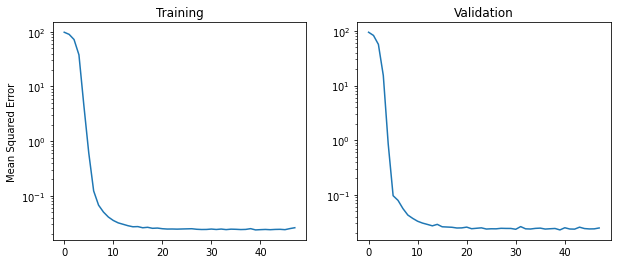

In [9]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

### Creating the Wide Networks

In [10]:
def crossed_outputs(idx, input_crossed):
    col = cross_col_names[idx]
    N = merc_info[col].max()+1
    x = tf.gather(input_crossed, 0, axis=1)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    return x

In [11]:
X_train_crossed_0 = X_train_df[cross_col_names[0]].to_numpy()
X_test_crossed_0  = X_test_df[cross_col_names[0]].to_numpy()
input_crossed_0  = Input(shape=(1,), dtype='int64', name='crossed_categorical')
output_crossed_0 = crossed_outputs(0, input_crossed_0)

wide_branch_0 = Dense(units=1, kernel_initializer=initializer, name='wide_0')(output_crossed_0)

model = Model(inputs=input_crossed_0, outputs=wide_branch_0)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
X_train_crossed_1 = X_train_df[cross_col_names[1]].to_numpy()
X_test_crossed_1  = X_test_df[cross_col_names[1]].to_numpy()
input_crossed_1  = Input(shape=(1,), dtype='int64', name='crossed_categorical')
output_crossed_1 = crossed_outputs(1, input_crossed_1)

wide_branch_1 = Dense(units=1, kernel_initializer=initializer, name='wide_1')(output_crossed_1)

model = Model(inputs=input_crossed_1, outputs=wide_branch_1)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [13]:
X_train_crossed_2 = X_train_df[cross_col_names[2]].to_numpy()
X_test_crossed_2  = X_test_df[cross_col_names[2]].to_numpy()
input_crossed_2  = Input(shape=(1,), dtype='int64', name='crossed_categorical')
output_crossed_2 = crossed_outputs(2, input_crossed_2)

wide_branch_2 = Dense(units=1, kernel_initializer=initializer, name='wide_2')(output_crossed_2)

model = Model(inputs=input_crossed_2, outputs=wide_branch_2)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [14]:
X_train_crossed = X_train_df[cross_col_names].to_numpy()
X_test_crossed  = X_test_df[cross_col_names].to_numpy()

output_crossed = []
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='crossed_categorical')
for idx,col in enumerate(cross_col_names):
    N = merc_info[col].max()+1
    x = tf.gather(input_crossed, idx, axis=1)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    output_crossed.append(x)

wide_branch = concatenate(output_crossed, name='wide_concat')
wide_branch_output = Dense(units=1, kernel_initializer=initializer, name='wide_output')(wide_branch)

model = Model(inputs=input_crossed, outputs=wide_branch_output)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Combining the Networks

In [15]:
wide_deep_0 = concatenate([output_crossed_0, deep_branch_3], axis=1)
wide_deep_0 = Dense(units=1, kernel_initializer=initializer)(wide_deep_0)
model = Model(inputs=[input_crossed_0, input_cat, input_num], outputs=wide_deep_0)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed_0, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed_0, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 13ms/step - loss: 96.8160 - mean_squared_error: 96.8160 - val_loss: 78.2028 - val_mean_squared_error: 78.2028
Epoch 2/256
21/21 [==============================] - 0s 4ms/step - loss: 71.2585 - mean_squared_error: 71.2585 - val_loss: 47.8740 - val_mean_squared_error: 47.8740
Epoch 3/256
21/21 [==============================] - 0s 4ms/step - loss: 39.4681 - mean_squared_error: 39.4681 - val_loss: 14.8938 - val_mean_squared_error: 14.8938
Epoch 4/256
21/21 [==============================] - 0s 6ms/step - loss: 9.4476 - mean_squared_error: 9.4476 - val_loss: 0.1766 - val_mean_squared_error: 0.1766
Epoch 5/256
21/21 [==============================] - 0s 6ms/step - loss: 0.1397 - mean_squared_error: 0.1397 - val_loss: 0.2284 - val_mean_squared_error: 0.2284
Epoch 6/256
21/21 [==============================] - 0s 8ms/step - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.0321 - val_mean_squared_error: 0.0321
Epoch 7/256
21/21 [==

Text(0.5, 1.0, 'Validation')

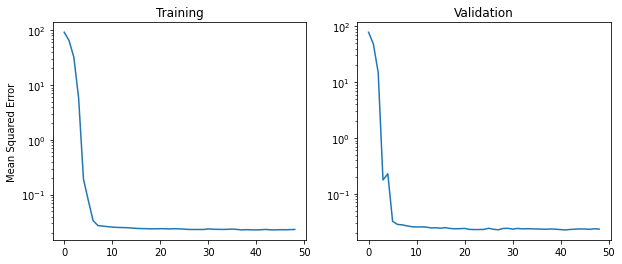

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

In [17]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [18]:
wide_deep_1 = concatenate([output_crossed_1, deep_branch_3], axis=1)
wide_deep_1 = Dense(units=1, kernel_initializer=initializer)(wide_deep_1)
model = Model(inputs=[input_crossed_1, input_cat, input_num], outputs=wide_deep_1)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed_1, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed_1, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 11ms/step - loss: 212.8490 - mean_squared_error: 212.8490 - val_loss: 151.2153 - val_mean_squared_error: 151.2153
Epoch 2/256
21/21 [==============================] - 0s 4ms/step - loss: 138.5149 - mean_squared_error: 138.5149 - val_loss: 106.2852 - val_mean_squared_error: 106.2852
Epoch 3/256
21/21 [==============================] - 0s 3ms/step - loss: 98.6867 - mean_squared_error: 98.6867 - val_loss: 76.8283 - val_mean_squared_error: 76.8283
Epoch 4/256
21/21 [==============================] - 0s 4ms/step - loss: 70.1738 - mean_squared_error: 70.1738 - val_loss: 49.5304 - val_mean_squared_error: 49.5304
Epoch 5/256
21/21 [==============================] - 0s 3ms/step - loss: 42.6388 - mean_squared_error: 42.6388 - val_loss: 21.9835 - val_mean_squared_error: 21.9835
Epoch 6/256
21/21 [==============================] - 0s 4ms/step - loss: 16.4636 - mean_squared_error: 16.4636 - val_loss: 3.4871 - val_mean_squared_error: 3.4871
Epo

Text(0.5, 1.0, 'Validation')

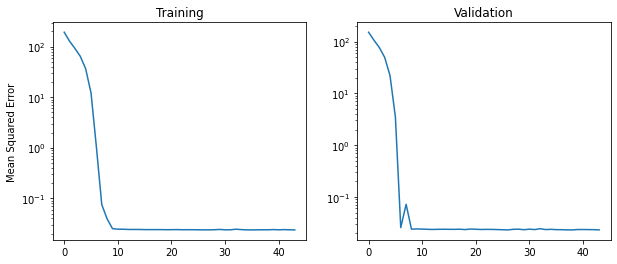

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

In [20]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [21]:
wide_deep_2 = concatenate([output_crossed_2, deep_branch_3], axis=1)
wide_deep_2 = Dense(units=1, kernel_initializer=initializer)(wide_deep_2)
model = Model(inputs=[input_crossed_2, input_cat, input_num], outputs=wide_deep_2)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed_2, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed_2, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 15ms/step - loss: 4.1215 - mean_squared_error: 4.1215 - val_loss: 0.5312 - val_mean_squared_error: 0.5312
Epoch 2/256
21/21 [==============================] - 0s 4ms/step - loss: 0.3414 - mean_squared_error: 0.3414 - val_loss: 0.0882 - val_mean_squared_error: 0.0882
Epoch 3/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 4/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 5/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 6/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 7/256
21/21 [==============

Text(0.5, 1.0, 'Validation')

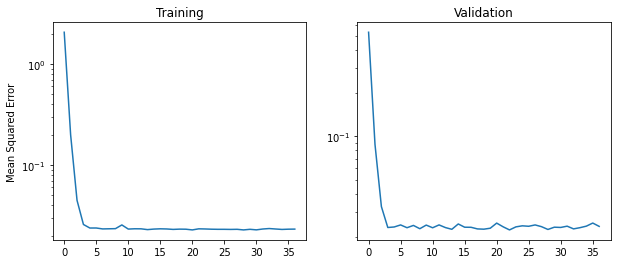

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

In [23]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [24]:
wide_deep = concatenate([wide_branch, deep_branch_3], axis=1)
wide_deep = Dense(units=1, kernel_initializer=initializer)(wide_deep)
model = Model(inputs=[input_crossed, input_cat, input_num], outputs=wide_deep)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 10ms/step - loss: 82.5104 - mean_squared_error: 82.5104 - val_loss: 30.8120 - val_mean_squared_error: 30.8120
Epoch 2/256
21/21 [==============================] - 0s 4ms/step - loss: 20.1800 - mean_squared_error: 20.1800 - val_loss: 0.7699 - val_mean_squared_error: 0.7699
Epoch 3/256
21/21 [==============================] - 0s 3ms/step - loss: 0.3451 - mean_squared_error: 0.3451 - val_loss: 0.4528 - val_mean_squared_error: 0.4528
Epoch 4/256
21/21 [==============================] - 0s 3ms/step - loss: 0.2643 - mean_squared_error: 0.2643 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 5/256
21/21 [==============================] - 0s 3ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0245 - val_mean_squared_error: 0.0245
Epoch 6/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 7/256
21/21 [========

21/21 [==============================] - 0s 4ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 52/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 53/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 54/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 55/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 56/256
21/21 [==============================] - 0s 4ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0228 - val_mean_squared_error: 0.0228
Epoch 57/256
21/21 [=====================

Text(0.5, 1.0, 'Validation')

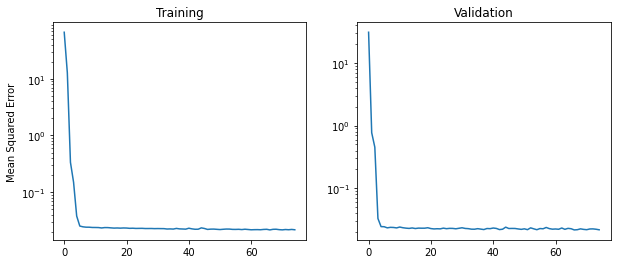

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

In [26]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Altering the Number of Layers

#### Cross Validation

In [27]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=1234)

X_crossed = merc_info[cross_col_names].to_numpy()
X_cat     = merc_info[categorical_headers_ints].to_numpy()
X_num     = merc_info[numerical].to_numpy()
y         = merc_info['log_price'].to_numpy()

deep_branches = [
    deep_branch_0,
    deep_branch_1,
    deep_branch_2,
    deep_branch_3
]

eval_scores = {}
for model_no, deep_branch in enumerate(deep_branches):
    
    fold_no = 0
    eval_scores[model_no] = []
    for train_index, test_index in kf.split(X, y):
        X_train_crossed, X_test_crossed = X_crossed[train_index], X_crossed[test_index]
        X_train_cat,     X_test_cat     = X_cat[train_index],     X_cat[test_index]
        X_train_num,     X_test_num     = X_num[train_index],     X_num[test_index]
        y_train,         y_test         = y[train_index],         y[test_index]
        
        wide_deep = concatenate([wide_branch, deep_branch], axis=1)
        wide_deep = Dense(units=1, kernel_initializer=initializer)(wide_deep)
        model = Model(inputs=[input_crossed, input_cat, input_num], outputs=wide_deep)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        history = model.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
                            epochs=epochs, batch_size=batch_size, callbacks = callbacks, verbose=0)

        scores = model.evaluate([X_test_crossed, X_test_cat, X_test_num], y_test, verbose=0)
        print(f"SCORE FOR MODEL {model_no} FOLD {fold_no}: MSE = {round(scores[1], 5)})")
        
        eval_scores[model_no].append(scores[1])
    
        fold_no += 1
    print(f"MEAN SCORE FOR MODEL {model_no}: MSE = {round(np.mean(eval_scores[model_no]), 5)}")

SCORE FOR MODEL 0 FOLD 0: MSE = 0.01934)
SCORE FOR MODEL 0 FOLD 1: MSE = 0.01878)
SCORE FOR MODEL 0 FOLD 2: MSE = 0.0181)
SCORE FOR MODEL 0 FOLD 3: MSE = 0.04228)
SCORE FOR MODEL 0 FOLD 4: MSE = 0.02047)
SCORE FOR MODEL 0 FOLD 5: MSE = 0.0219)
SCORE FOR MODEL 0 FOLD 6: MSE = 0.01828)
SCORE FOR MODEL 0 FOLD 7: MSE = 0.02224)
SCORE FOR MODEL 0 FOLD 8: MSE = 0.02255)
SCORE FOR MODEL 0 FOLD 9: MSE = 0.01969)
MEAN SCORE FOR MODEL 0: MSE = 0.02236
SCORE FOR MODEL 1 FOLD 0: MSE = 0.01933)
SCORE FOR MODEL 1 FOLD 1: MSE = 0.0189)
SCORE FOR MODEL 1 FOLD 2: MSE = 0.01813)
SCORE FOR MODEL 1 FOLD 3: MSE = 0.04294)
SCORE FOR MODEL 1 FOLD 4: MSE = 0.01934)
SCORE FOR MODEL 1 FOLD 5: MSE = 0.02152)
SCORE FOR MODEL 1 FOLD 6: MSE = 0.01769)
SCORE FOR MODEL 1 FOLD 7: MSE = 0.0222)
SCORE FOR MODEL 1 FOLD 8: MSE = 0.02157)
SCORE FOR MODEL 1 FOLD 9: MSE = 0.01991)
MEAN SCORE FOR MODEL 1: MSE = 0.02215
SCORE FOR MODEL 2 FOLD 0: MSE = 0.01947)
SCORE FOR MODEL 2 FOLD 1: MSE = 0.01884)
SCORE FOR MODEL 2 FOLD 2: 

In [28]:
scores = [np.mean(eval_scores[k]) for k in eval_scores]
best_model = np.argmin(scores)

wide_deep = concatenate([wide_branch, deep_branches[best_model]], axis=1)
wide_deep = Dense(units=1, kernel_initializer=initializer)(wide_deep)
best_model = Model(inputs=[input_crossed, input_cat, input_num], outputs=wide_deep)
best_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

plot_model(
    best_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [29]:
from tensorflow.keras import Sequential

tf.keras.backend.set_floatx('float64')
X_mlp = merc_info[numerical]

for col in categorical_headers_ints:
    X_mlp = pd.concat([X_mlp,pd.get_dummies(merc_info[col], prefix=col)],axis=1)
    
X_mlp = X_mlp.to_numpy()

fold_no = 0
mlp_scores = []
for train_index, test_index in kf.split(X_mlp, y):
    X_train, X_test = X_mlp[train_index], X_mlp[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mlp = Sequential()
    mlp.add(Dense(20, kernel_initializer=initializer))
    mlp.add(Dense(10, kernel_initializer=initializer))
    mlp.add(Dense(5, kernel_initializer=initializer))
    mlp.add(Dense(1, kernel_initializer=initializer))
    mlp.compile(optimizer=optimizer, loss=loss, metrics = metrics)
    history = mlp.fit(X_train, y_train,
                        epochs=epochs, batch_size=batch_size, callbacks = callbacks, verbose=0)

    scores = mlp.evaluate(X_test, y_test, verbose=0)
    print(f"SCORE FOR MODEL MLP FOLD {fold_no}: MSE = {round(scores[1], 5)})")

    mlp_scores.append(scores[1])

    fold_no += 1
    
print("MEAN SCORE FOR MODEL MLP: MSE =",np.mean(mlp_scores))

SCORE FOR MODEL MLP FOLD 0: MSE = 0.02106)
SCORE FOR MODEL MLP FOLD 1: MSE = 0.02092)
SCORE FOR MODEL MLP FOLD 2: MSE = 0.02158)
SCORE FOR MODEL MLP FOLD 3: MSE = 0.04327)
SCORE FOR MODEL MLP FOLD 4: MSE = 0.02121)
SCORE FOR MODEL MLP FOLD 5: MSE = 0.03154)
SCORE FOR MODEL MLP FOLD 6: MSE = 0.02569)
SCORE FOR MODEL MLP FOLD 7: MSE = 0.031)
SCORE FOR MODEL MLP FOLD 8: MSE = 0.0237)
SCORE FOR MODEL MLP FOLD 9: MSE = 0.02296)
MEAN SCORE FOR MODEL MLP: MSE = 0.026292156356526413


In [30]:
mlp = Sequential()
mlp.add(Dense(20, kernel_initializer=initializer))
mlp.add(Dense(10, kernel_initializer=initializer))
mlp.add(Dense(5, kernel_initializer=initializer))
mlp.add(Dense(1, kernel_initializer=initializer))
mlp.compile(optimizer=optimizer, loss=loss, metrics = metrics)

plot_model(
    mlp, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [31]:
best_model.fit([X_crossed, X_cat, X_num], y, validation_split=.2,
               epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)
mlp.fit(X_mlp, y, validation_split=.2,
               epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)

In [32]:
from pyCompare import blandAltman

data_1 = best_model.predict([X_crossed, X_cat, X_num]).reshape(-1)
data_2 = mlp.predict(X_mlp).reshape(-1)

blandAltman(data_1, data_2)

ModuleNotFoundError: No module named 'pyCompare'

## Exceptional Work (1 pt)

<ul>
    <li> 5000 students: You have free reign to provide additional analyses. </li> 
    <li>One idea (<b>required for 7000 level students</b>): Capture the embedding weights from the deep network and (<b>if needed</b>) perform dimensionality reduction on the output of these embedding layers (<b>only if needed</b>). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data. </li>
</ul>